In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, colors
from datetime import datetime, timedelta
from salishsea_tools import nc_tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

### Theory

The effect of surface wave breaking on TKE ($\overline{e}$) is parameterized in NEMO in the following two ways (Madec et al. 2017).

   1. The wind stress coefficient $\alpha_{CB}$ (`rn_crban`) in the surface TKE boundary condition

$$\overline{e}_0 = \frac{1}{2}\left(15.8\alpha_{CB}\right)^{2/3}\frac{|\tau|}{\rho_0}$$

   2. The wind stress coefficient $\beta$ (`rn_charn`) in the surface dissipation length scale boundary condition (Charnock's relation)

$$l_0 = \kappa\beta\frac{|\tau|}{g\rho_0}$$

For a generic ocean, NEMO assigns default values of $\alpha_{CB} = 100$ from Craig and Banner (1994, JPO) and $\beta = 2\times10^5$ from Stacey (1999, JPO). Actually, in GLS $\beta = 7\times10^4$ but this value is undocumented.

In practice, these parameters vary widely according to sea state and fetch, and should almost certainly be tuned for the Salish Sea (although Stacey's $\beta$ is based on observations in Knight Inlet). The coefficients $\alpha_{CB}$ and $\beta$ have been empirically determined in several studies, but we can start with the NEMO authors' primary reference (Mellor and Blumberg 2004, JPO).


$$\alpha_{CB} = 15\frac{c_p}{u_*}\exp\left\{-\left(0.04\frac{c_p}{u_*}\right)^4\right\} \hspace{0.5cm} \text{(cited from Terray et al. 1996, 1997 JPO)}$$

$$\beta \approx 665\left(\frac{c_p}{u_*}\right)^{1.5} \hspace{0.5cm} \text{(cited from Donelan 1990, Smith et al. 1992, Janssen 2001)}$$

Here $c_p/u_*$ is defined as the "wave age" parameter, where $c_p$ is the phase speed and $u_*$ is the air side friction velocity. Since both $\alpha_{CB}$ and $\beta$ depend on $c_p/u_*$, we can start by coupling the two parameters.

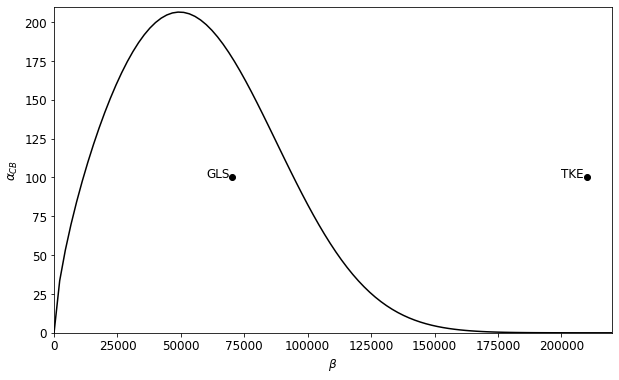

In [17]:
# Plot alpha_CB vs beta
fig, ax = plt.subplots(figsize=(10, 6))
beta = np.linspace(0, 2.2e5, 100)
cpu_star = (beta / 665)**(2/3)
alpha_CB = 15 * cpu_star * np.exp(-(0.04 * cpu_star)**4)
ax.plot(beta, alpha_CB, 'k-')
ax.plot([7e4, 2.1e5], [100, 100], 'ko')
ax.text(6e4, 100, 'GLS')
ax.text(2e5, 100, 'TKE')
ax.set_xlim([0, 2.2e5])
ax.set_ylim([0, 210])
ax.set_xlabel('$\\beta$')
ax.set_ylabel('$\\alpha_{CB}$')
plt.show()

Immediately we can see the GLS choice of $\beta$ is much closer the the wave age dependence summarized by Mellor and Blumberg than the TKE choice from Stacey.

In [80]:
def calc_Cd(wspd):
    """Calculate the surface drag coefficient according to
    Hellerman and Rosenstein (1983) JPO, neglecting T effects
    """
    
    # Coefficients
    a_1 = 0.934e-3
    a_2 = 0.788e-4
    a_3 = 0.868e-4
    a_4 = -0.616e-6
    a_5 = -0.120e-5
    a_6 = -0.214e-5

    # Neglect temperature gradient
    Delta_T = 0

    # Calc C_d
    C_d = a_1 + a_2 * wspd + a_3 * Delta_T + a_4 * wspd**2 + a_5 * Delta_T**2 + a_6 * wspd * Delta_T
    
    return C_d

In [110]:
date = datetime(2020, 1, 1)
fn = nc_tools.get_WW3_path(date)
with xr.open_dataset(fn).isel(latitude=slice(160, 450), longitude=slice(120, 470)) as ds:
    hs = ds.hs.values.flatten()
    U2 = np.add(*[ds[var]**2 for var in ('uwnd', 'vwnd')]).values.flatten()

tau_plot = np.arange(0, 0.51, 0.01)
tau = 1.223 * calc_Cd(np.sqrt(U2)) * U2
index = np.logical_and(~np.isnan(tau), hs > 0)
beta, rho_0, g = 7e4, 1030, 9.81
z0 = beta * tau_plot / (rho_0 * g)

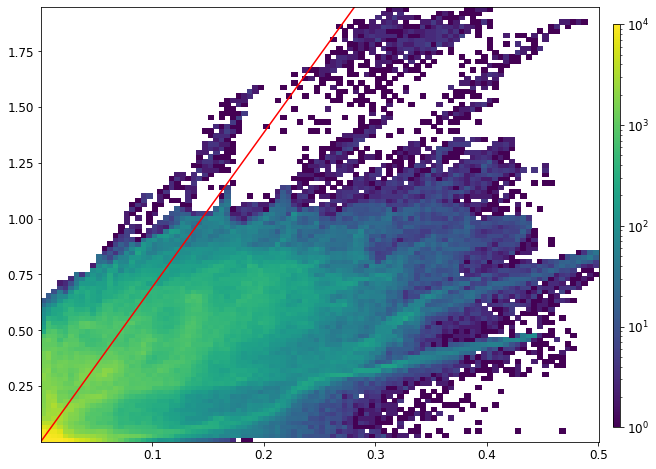

In [111]:
fig, ax = plt.subplots(figsize=(10, 8))
_, _, _, c = ax.hist2d(tau[index], hs[index], bins=100, norm=colors.LogNorm(vmin=1, vmax=10000))
ax.plot(tau_plot, z0, 'r-')
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax)

In [ ]:
date = datetime(2020, 1, 1)
fn = nc_tools.get_WW3_path(date)
with xr.open_dataset(fn) as ds:
    for var in ds.variables:
        